In [1]:
import numpy as np

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import BasicAer
from qiskit.compiler import transpile
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import process_fidelity

from qiskit.extensions import RXGate, XGate, CXGate

In [5]:
#The Operator class is used in Qiskit to represent matrix operators acting on a quantum system. 
#It has several methods to build composite operators using tensor products of smaller operators, and to compose operators.
#Creating Operators
#The easiest way to create an operator object is to initialize it with a matrix given as a list or a Numpy array. 
#For example, to create a two-qubit Pauli-XX operator:
XX = Operator([[0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0], [1, 0, 0, 0]])
XX

Operator([[0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
          [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))

In [3]:
#The operator object stores the underlying matrix, and the input and output dimension of subsystems.
#data: To access the underlying Numpy array, we may use the Operator.data property.
#dims: To return the total input and output dimension of the operator, we may use the Operator.dim property.
#Note: the output is returned as a tuple (input_dim, output_dim), which is the reverse of the shape of the underlying matrix.
XX.data

array([[0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

In [6]:
#The operator class also keeps track of subsystem dimensions, which can be used for composing operators together.
#These can be accessed using the input_dims and output_dims functions.
#For 2N by 2M operators, the input and output dimension will be automatically assumed to be M-qubit and N-qubit:
input_dim, output_dim = XX.dim
input_dim, output_dim


(4, 4)

In [7]:
op = Operator(np.random.rand(2 ** 1, 2 ** 2))
print('Input dimensions:', op.input_dims())
print('Output dimensions:', op.output_dims())

Input dimensions: (2, 2)
Output dimensions: (2,)


In [8]:
#If the input matrix is not divisible into qubit subsystems, then it will be stored as a single-qubit operator. 
#For example, if we have a 6×6 matrix:
op = Operator(np.random.rand(6, 6))
print('Input dimensions:', op.input_dims())
print('Output dimensions:', op.output_dims())

Input dimensions: (6,)
Output dimensions: (6,)


In [9]:
# Force input dimension to be (4,) rather than (2, 2)
op = Operator(np.random.rand(2 ** 1, 2 ** 2), input_dims=[4])
print('Input dimensions:', op.input_dims())
print('Output dimensions:', op.output_dims())

Input dimensions: (4,)
Output dimensions: (2,)


In [10]:
# Specify system is a qubit and qutrit
op = Operator(np.random.rand(6, 6),
              input_dims=[2, 3], output_dims=[2, 3])
print('Input dimensions:', op.input_dims())
print('Output dimensions:', op.output_dims())

Input dimensions: (2, 3)
Output dimensions: (2, 3)


In [11]:
print('Dimension of input system 0:', op.input_dims([0]))
print('Dimension of input system 1:', op.input_dims([1]))

Dimension of input system 0: (2,)
Dimension of input system 1: (3,)


In [15]:
# Several other classes in Qiskit can be directly converted to an Operator object using the operator initialization method. 
# For example:
# Pauli objects
# Gate and Instruction objects
# QuantumCircuits objects
# Create an Operator from a Pauli object
pauliXX = Pauli('XX')
Operator(pauliXX)

Operator([[0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
          [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))

In [13]:
# Create an Operator for a Gate object
Operator(CXGate())

Operator([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))

In [16]:
# Create an operator from a parameterized Gate object
Operator(RXGate(np.pi / 2))

Operator([[0.70710678+0.j        , 0.        -0.70710678j],
          [0.        -0.70710678j, 0.70710678+0.j        ]],
         input_dims=(2,), output_dims=(2,))

In [17]:
# Create an operator from a QuantumCircuit object
circ = QuantumCircuit(10)
circ.h(0)
for j in range(1, 10):
    circ.cx(j-1, j)

# Convert circuit to an operator by implicit unitary simulation
Operator(circ)

Operator([[ 0.70710678+0.j,  0.70710678+0.j,  0.        +0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j],
          [ 0.        +0.j,  0.        +0.j,  0.70710678+0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j],
          [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j],
          ...,
          [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j],
          [ 0.        +0.j,  0.        +0.j,  0.70710678+0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j],
          [ 0.70710678+0.j, -0.70710678+0.j,  0.        +0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j]],
         input_dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2), output_dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2))

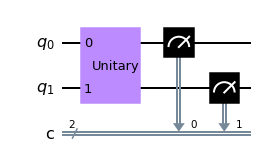

In [18]:
# Unitary Operators can be directly inserted into a QuantumCircuit using the QuantumCircuit.append method. 
# This converts the Operator into a UnitaryGate object, which is added to the circuit.
# If the operator is not unitary, an exception will be raised. 
# This can be checked using the Operator.is_unitary() function, which will return True if the operator is unitary and False otherwise.
# Create an operator
XX = Operator(Pauli(label='XX'))

# Add to a circuit
circ = QuantumCircuit(2, 2)
circ.append(XX, [0, 1])
circ.measure([0,1], [0,1])
circ.draw('mpl')

In [19]:
backend = BasicAer.get_backend('qasm_simulator')
circ = transpile(circ, backend, basis_gates=['u1','u2','u3','cx'])
job = backend.run(circ)
job.result().get_counts(0)

{'11': 1024}

In [20]:
# Add to a circuit
circ2 = QuantumCircuit(2, 2)
circ2.append(Pauli(label='XX'), [0, 1])
circ2.measure([0,1], [0,1])
circ2.draw()

┌────────────┐┌─┐   
q_0: ┤0           ├┤M├───
     │  Pauli(XX) │└╥┘┌─┐
q_1: ┤1           ├─╫─┤M├
     └────────────┘ ║ └╥┘
c: 2/═══════════════╩══╩═
                    0  1

In [21]:
#tensor product
#A.tensor(B) = A⊗B 
A = Operator(Pauli(label='X'))
B = Operator(Pauli(label='Z'))
A.expand(B)


Operator([[ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
          [ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j, -0.+0.j, -1.+0.j],
          [ 0.+0.j,  0.+0.j, -1.+0.j, -0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))

In [22]:
#A.compose(B) returns the operator with matrix B.A
A = Operator(Pauli(label='X'))
B = Operator(Pauli(label='Z'))
A.compose(B)

Operator([[ 0.+0.j,  1.+0.j],
          [-1.+0.j,  0.+0.j]],
         input_dims=(2,), output_dims=(2,))

In [23]:
#compose: A.compose(B, front=True) = A.B
A = Operator(Pauli(label='X'))
B = Operator(Pauli(label='Z'))
A.compose(B, front=True)

Operator([[ 0.+0.j, -1.+0.j],
          [ 1.+0.j,  0.+0.j]],
         input_dims=(2,), output_dims=(2,))

In [24]:
# Compose XZ with an 3-qubit identity operator
op = Operator(np.eye(2 ** 3))
XZ = Operator(Pauli(label='XZ'))
op.compose(XZ, qargs=[0, 2])

Operator([[ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
           -1.+0.j],
          [ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j]],
         input_dims=(2, 2, 2), output_dims=(2, 2, 2))

In [25]:
# Compose YX in front of the previous operator
op = Operator(np.eye(2 ** 3))
YX = Operator(Pauli(label='YX'))
op.compose(XZ, qargs=[0, 2], front=True)

Operator([[ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
           -1.+0.j],
          [ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j]],
         input_dims=(2, 2, 2), output_dims=(2, 2, 2))

In [26]:
#linear combinations
XX = Operator(Pauli(label='XX'))
YY = Operator(Pauli(label='YY'))
ZZ = Operator(Pauli(label='ZZ'))

op = 0.5 * (XX + YY - 3 * ZZ)
op

Operator([[-1.5+0.j,  0. +0.j,  0. +0.j,  0. +0.j],
          [ 0. +0.j,  1.5+0.j,  1. +0.j,  0. +0.j],
          [ 0. +0.j,  1. +0.j,  1.5+0.j,  0. +0.j],
          [ 0. +0.j,  0. +0.j,  0. +0.j, -1.5+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))

In [28]:
op.is_unitary()
#adding two unitary operators will, in general, result in a non-unitary operator

False

In [29]:
# Compose with a matrix passed as a list
Operator(np.eye(2)).compose([[0, 1], [1, 0]])

Operator([[0.+0.j, 1.+0.j],
          [1.+0.j, 0.+0.j]],
         input_dims=(2,), output_dims=(2,))

In [30]:
#comparision of operators
Operator(Pauli(label='X')) == Operator(XGate())

True

In [31]:
Operator(XGate()) == np.exp(1j * 0.5) * Operator(XGate())

False

In [32]:
# compare operators using the process_fidelity function from the Quantum Information module.
#This is an information theoretic quantity for how close two quantum channels are to each other, and in the case of unitary operators it does not depend on global phase.
# Two operators which differ only by phase
op_a = Operator(XGate())
op_b = np.exp(1j * 0.5) * Operator(XGate())

# Compute process fidelity
F = process_fidelity(op_a, op_b)
print('Process fidelity =', F)

Process fidelity = 1.0
